In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("./data/customer_features_cleaned.csv")

In [3]:
print(df.columns.tolist())


['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country', 'TotalPrice', 'Year', 'Month', 'Day', 'Hour', 'Weekday', 'DateOnly', 'Revenue']


In [4]:
# Chuẩn hóa tên cột
df.columns = df.columns.str.strip()

# Tính TotalRevenue nếu chưa có
df['TotalRevenue'] = df['Quantity'] * df['Price']

# Gom nhóm theo StockCode
stock_df = df.groupby('StockCode').agg(
    total_quantity=('Quantity', 'sum'),
    total_revenue=('TotalRevenue', 'sum'),
    avg_price=('Price', 'mean'),
    num_customers=('Customer ID', pd.Series.nunique),
    num_invoices=('Invoice', pd.Series.nunique),
    num_countries=('Country', pd.Series.nunique),
).reset_index()

# Tính return_rate
returns = df[df['Quantity'] < 0].groupby('StockCode')['Quantity'].count()
total = df.groupby('StockCode')['Quantity'].count()


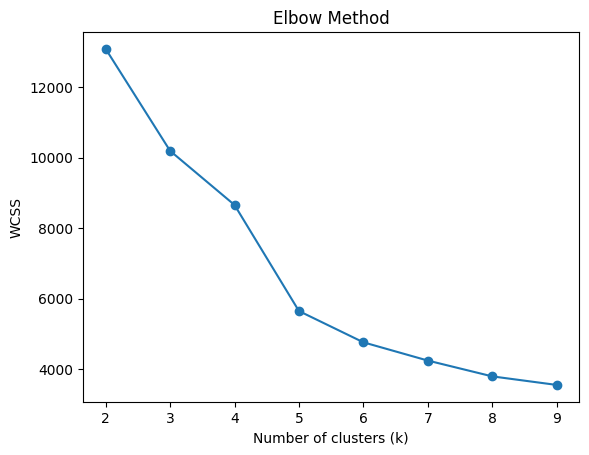

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Chọn feature để phân cụm
features = ['total_quantity', 'total_revenue', 'avg_price', 'num_customers', 'num_invoices']
X = stock_df[features]

# Chuẩn hóa
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method để chọn số cụm k
wcss = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 10), wcss, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.show()

In [6]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
stock_df['cluster'] = kmeans.fit_predict(X_scaled)  # X_scaled là dữ liệu đã chuẩn hóa


,total_quantity,total_revenue,avg_price,num_customers,num_invoices
cluster,,,,,
0,10131.713483,20616.417640,2.706528,530.797753,1117.601124
1,600.962464,724.553935,1.694009,52.975583,68.457726
2,3706.185022,6247.635286,2.285438,268.236417,428.146843
3,34497.714286,82089.402857,2.993349,1092.285714,3041.428571
4,235.978452,1345.253311,6.239402,50.719882,67.860921


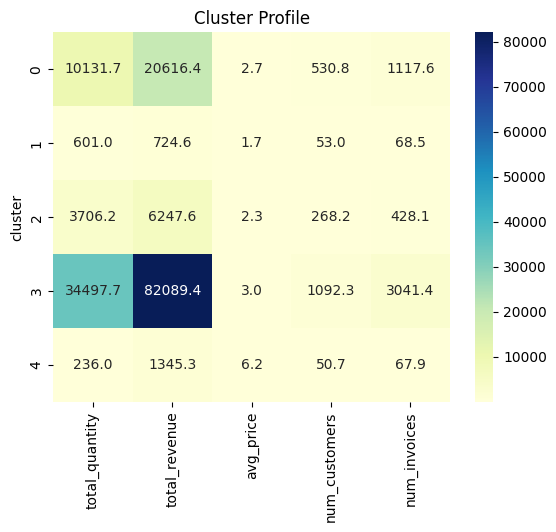

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# So sánh trung bình các đặc trưng theo từng cụm
cluster_profile = stock_df.groupby('cluster')[features].mean()
display(cluster_profile)

# Vẽ heatmap cho trực quan
sns.heatmap(cluster_profile, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Cluster Profile")
plt.show()


## Phân Cụm Sản Phẩm Theo Hành Vi Mua Hàng

### Mô tả

Dữ liệu được phân cụm theo `StockCode` bằng thuật toán **KMeans (k = 5)**. Các đặc trưng đầu vào gồm:

- `total_quantity`: Tổng số lượng sản phẩm bán ra
- `total_revenue`: Tổng doanh thu
- `avg_price`: Giá bán trung bình
- `num_customers`: Số khách hàng đã mua
- `num_invoices`: Số hóa đơn có chứa sản phẩm

---

### Hồ sơ cụm (Cluster Profile)

| Cụm | Tên gợi ý                   | Phân tích hành vi |
|-----|------------------------------|--------------------|
| **Cluster 0** | **Sản phẩm phổ thông** | Giá rẻ (~2.7), được mua tương đối nhiều (10k+), doanh thu khá (~20k), khách hàng rộng (530+) |
| **Cluster 1** | **Sản phẩm ít phổ biến** | Giá thấp (~1.7), ít khách mua, ít hóa đơn. Có thể là phụ kiện phụ hoặc sản phẩm lỗi thời |
| **Cluster 2** | **Sản phẩm tiềm năng** | Mức mua và doanh thu trung bình, giá rẻ, khách hàng tầm trung. Có thể đẩy mạnh marketing để tăng trưởng |
| **Cluster 3** | **Sản phẩm chủ lực (best-seller)** | Tốt nhất về mọi mặt: doanh thu (82k), số lượng (34k), khách hàng (~1k), hóa đơn (~3k) |
| **Cluster 4** | **Sản phẩm cao cấp / niche** | Giá cao nhất (6.2), rất ít người mua. Có thể là sản phẩm đặc biệt, hàng cao cấp hoặc khó bán |

---

### Gợi ý chiến lược

- **Cluster 3 – Best-seller**:
  - Duy trì tồn kho ổn định
  - Ưu tiên hiển thị trên web/app
  - Tạo combo gắn với sản phẩm này

- **Cluster 0 – Phổ thông**:
  - Thích hợp để làm quà tặng, bundle, bán kèm

- **Cluster 2 – Tiềm năng**:
  - Khai thác thêm qua remarketing hoặc khuyến mãi nhẹ

- **Cluster 1 – Ít phổ biến**:
  - Cân nhắc loại bỏ, hoặc gắn trong flash sale/clearance

- **Cluster 4 – Cao cấp**:
  - Định vị thương hiệu rõ ràng hơn, marketing hướng cá nhân hóa

---

### Ghi chú
- Các cụm được phân tách rõ theo giá trị và quy mô hành vi mua.
- `avg_price` giúp nhận diện được cụm sản phẩm cao cấp (cluster 4).
- `num_customers` và `num_invoices` là chỉ số quan trọng để xác định độ phổ biến của sản phẩm.

---


In [8]:
# Gán nhãn cụm bằng tiếng Anh dựa trên phân tích
cluster_labels = {
    0: "Mid-range Popular Product",
    1: "Low-demand Product",
    2: "Potential Product",
    3: "Bestseller Product",
    4: "High-end Niche Product"
}

stock_df['cluster_label'] = stock_df['cluster'].map(cluster_labels)

In [9]:
stock_df.to_csv('./data/product_clustering.csv')